In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import LearningRateScheduler


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow as tf

In [3]:
m = 50   
n_z = 2
n_epoch = 10

epsilon_std=1.0

inputs = Input(shape=(784,))
h_q = Dense(512, activation='relu')(inputs)
mu = Dense(n_z, activation='linear')(h_q)
log_sigma = Dense(n_z, activation='linear')(h_q)

In [4]:
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=epsilon_std)
    return mu + K.exp(log_sigma / 2) * eps

In [5]:
# Sample z ~ Q(z|X)
z = Lambda(sample_z)([mu, log_sigma])


In [6]:
# P(X|z) -- decoder
decoder_hidden = Dense(512, activation='relu')
decoder_out = Dense(784, activation='sigmoid')

h_p = decoder_hidden(z)
outputs = decoder_out(h_p)

In [8]:
print(outputs)

KerasTensor(type_spec=TensorSpec(shape=(50, 784), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")


In [9]:
# Overall VAE model, for reconstruction and training
vae = Model(inputs, outputs)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model(inputs, mu)

# Generator model, generate new data given latent variable z
d_in = Input(shape=(n_z,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
generator = Model(d_in, d_out)

In [10]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

    return recon + kl

In [11]:
from tensorflow.keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, y_test) = mnist.load_data()

In [12]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [13]:
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            1026        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            1026        dense[0][0]                      
______________________________________________________________________________________________

In [14]:
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(x_train, x_train, batch_size=m, epochs=n_epoch)

Epoch 1/10


TypeError: in user code:

    /home/mike/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/mike/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/mike/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/mike/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/mike/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/mike/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/mike/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:756 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /home/mike/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/keras/engine/compile_utils.py:238 __call__
        total_loss_metric_value, sample_weight=batch_dim)
    /home/mike/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/keras/utils/metrics_utils.py:90 decorated
        update_op = update_state_fn(*args, **kwargs)
    /home/mike/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/keras/metrics.py:177 update_state_fn
        return ag_update_state(*args, **kwargs)
    /home/mike/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/keras/metrics.py:364 update_state  **
        sample_weight, values)
    /home/mike/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/ops/weights_broadcast_ops.py:155 broadcast_weights
        values = ops.convert_to_tensor(values, name="values")
    /home/mike/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/profiler/trace.py:163 wrapped
        return func(*args, **kwargs)
    /home/mike/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:1540 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /home/mike/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/framework/constant_op.py:339 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    /home/mike/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/framework/constant_op.py:265 constant
        allow_broadcast=True)
    /home/mike/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/framework/constant_op.py:283 _constant_impl
        allow_broadcast=allow_broadcast))
    /home/mike/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:435 make_tensor_proto
        values = np.asarray(values)
    /home/mike/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83 asarray
        return array(a, dtype, copy=False, order=order)
    /home/mike/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/keras/engine/keras_tensor.py:274 __array__
        'Cannot convert a symbolic Keras input/output to a numpy array. '

    TypeError: Cannot convert a symbolic Keras input/output to a numpy array. This error may indicate that you're trying to pass a symbolic value to a NumPy call, which is not supported. Or, you may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model.


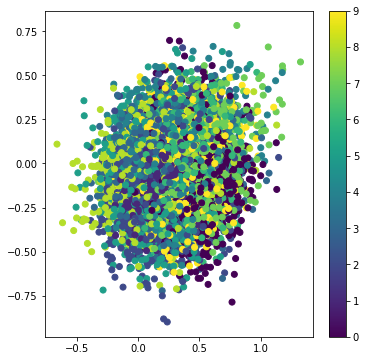

In [16]:
x_test_encoded = encoder.predict(x_test, batch_size=m)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()